# 📊 Exploratory Data Analysis (EDA)

## 🎯 Objective
- Explore the characteristics of the `US-CapydataViSportIC` dataset.
- Analyze data distribution to ensure quality.
- Examine caption-related features (length, word count, word frequency).
- Identify any anomalies or potential issues that may affect model training.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from PIL import Image, ImageStat
import re
from wordcloud import WordCloud
from tqdm import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Đường dẫn đến dữ liệu
data_root = "../data/ic_dataset/"
raw_images_path = "../data/raw_images/"
processed_captions_path = "../data/processed_captions.txt"

# Danh sách các môn thể thao
sports = [
    "Soccer", "Volleyball", "Baseball", "Tennis", "Basketball",
    "Badminton", "Swimming", "Surfing", "Archery", "Athletics",
    "Equestrianism", "Boxing", "Golf", "Skiing", "Cycling"
]

# Các màu sắc cho biểu đồ
colors = plt.cm.tab20(np.linspace(0, 1, len(sports)))

# Tạo thư mục để lưu kết quả phân tích
results_dir = "../data/eda_results/"
os.makedirs(results_dir, exist_ok=True)
os.makedirs(os.path.join(results_dir, "figures"), exist_ok=True)
os.makedirs(os.path.join(results_dir, "wordclouds"), exist_ok=True)
os.makedirs(os.path.join(results_dir, "samples"), exist_ok=True)

# Đọc dữ liệu file vietnamese-stopwords-dash.txt
with open("../data/vietnamese-stopwords-dash.txt", 'r', encoding='utf-8') as f:
    vietnamese_stopwords = set(line.strip() for line in f)

## 🔍 Data Inspector

In [3]:
# Đọc dữ liệu captions
def read_captions_file(file_path):
    captions_data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                image_name, caption = parts
                captions_data.append((image_name, caption))
    return captions_data

# Đọc captions từ file gốc
original_captions = read_captions_file(processed_captions_path)

# Đọc captions từ các tập split
train_captions = read_captions_file(os.path.join(data_root, "train", "captions.txt"))
val_captions = read_captions_file(os.path.join(data_root, "val", "captions.txt"))
test_captions = read_captions_file(os.path.join(data_root, "test", "captions.txt"))

print(f"Tổng số captions gốc: {len(original_captions)}")
print(f"Captions trong tập train: {len(train_captions)}")
print(f"Captions trong tập val: {len(val_captions)}")
print(f"Captions trong tập test: {len(test_captions)}")

Tổng số captions gốc: 9020
Captions trong tập train: 6275
Captions trong tập val: 1350
Captions trong tập test: 1395


In [4]:
# Map từ tên file ảnh gốc sang tên môn thể thao
def map_filename_to_sport(filename):
    for sport in sports:
        if filename.lower().startswith(sport.lower()):
            return sport
    return "Unknown"

# Đếm số ảnh và captions theo môn thể thao
def count_by_sport(captions_data):
    sport_images = defaultdict(set)
    sport_captions = defaultdict(int)
    
    for image_name, _ in captions_data:
        sport = map_filename_to_sport(image_name)
        sport_images[sport].add(image_name)
        sport_captions[sport] += 1
    
    return {sport: len(images) for sport, images in sport_images.items()}, sport_captions

# Thống kê số ảnh và captions theo môn thể thao
original_images_count, original_captions_count = count_by_sport(original_captions)

# Thống kê theo tập dữ liệu
train_images_count, train_captions_count = count_by_sport(train_captions)
val_images_count, val_captions_count = count_by_sport(val_captions)
test_images_count, test_captions_count = count_by_sport(test_captions)

# Tạo DataFrame để dễ dàng visualization
stats_df = pd.DataFrame({
    'Sport': sports,
    'Original_Images': [original_images_count.get(sport, 0) for sport in sports],
    'Original_Captions': [original_captions_count.get(sport, 0) for sport in sports],
    'Train_Images': [train_images_count.get(sport, 0) for sport in sports],
    'Train_Captions': [train_captions_count.get(sport, 0) for sport in sports],
    'Val_Images': [val_images_count.get(sport, 0) for sport in sports],
    'Val_Captions': [val_captions_count.get(sport, 0) for sport in sports],
    'Test_Images': [test_images_count.get(sport, 0) for sport in sports],
    'Test_Captions': [test_captions_count.get(sport, 0) for sport in sports],
})

# Tính số caption trung bình cho mỗi ảnh
stats_df['Avg_Captions_Per_Image'] = stats_df['Original_Captions'] / stats_df['Original_Images'].replace(0, np.nan)

# Lưu thống kê ra file
stats_df.to_csv(os.path.join(results_dir, "data_statistics.csv"), index=False)

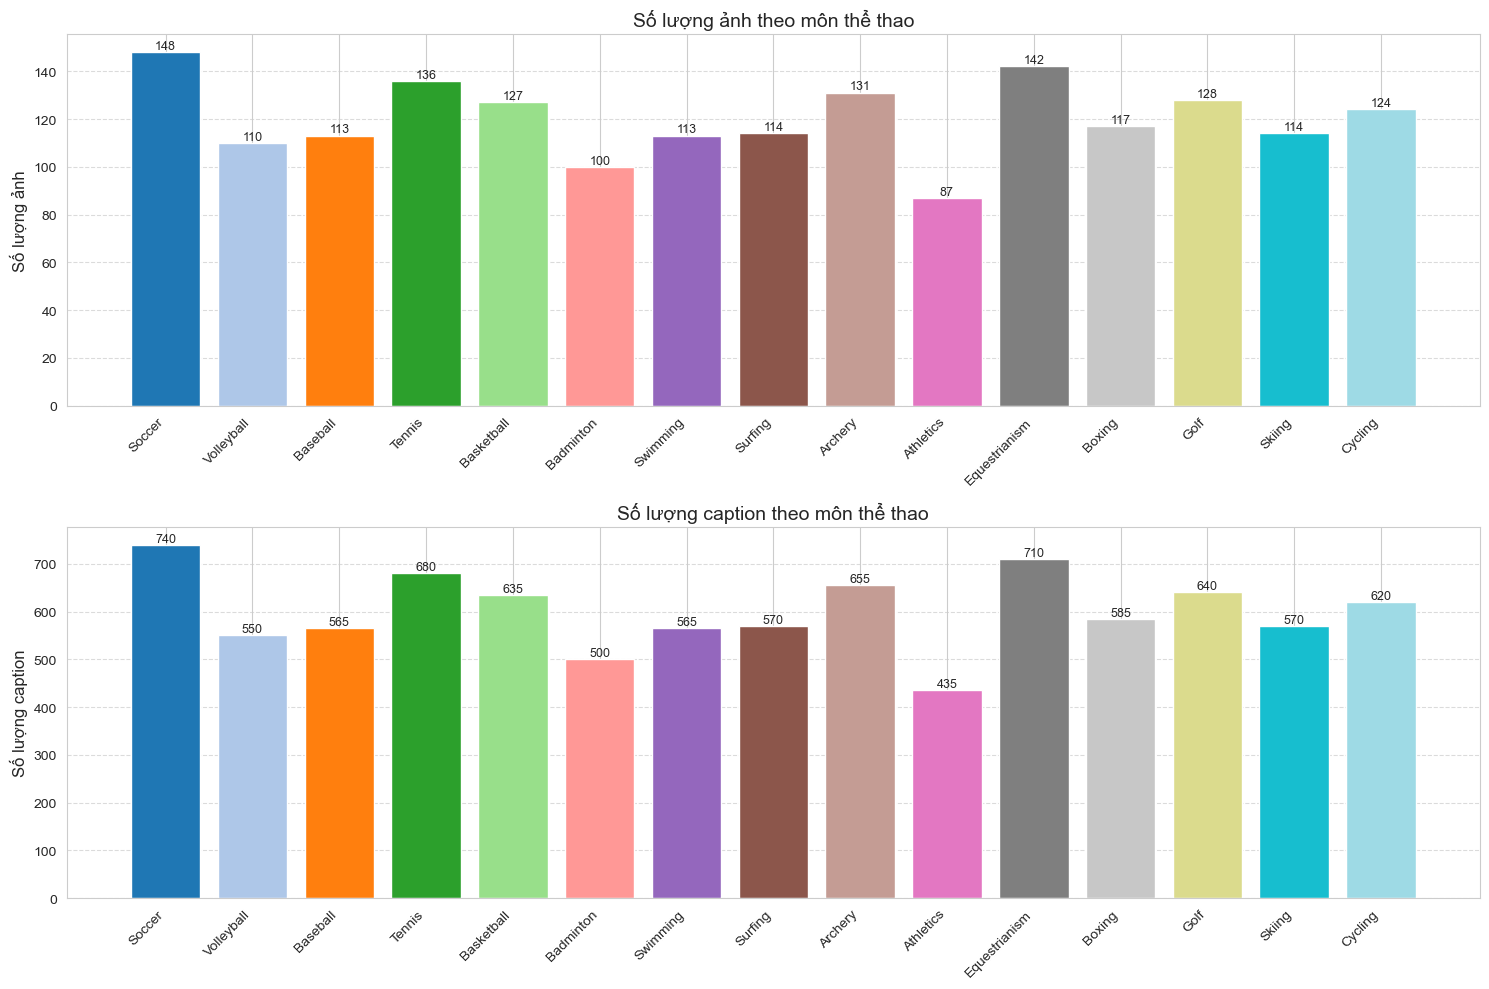

In [5]:
# Trực quan hóa phân bố ảnh và caption theo môn thể thao
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Biểu đồ số lượng ảnh
plt.subplot(2, 1, 1)
bars = plt.bar(stats_df['Sport'], stats_df['Original_Images'], color=colors)
plt.title('Số lượng ảnh theo môn thể thao', fontsize=14)
plt.ylabel('Số lượng ảnh', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm số lượng ảnh lên biểu đồ
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Biểu đồ số lượng caption
plt.subplot(2, 1, 2)
bars = plt.bar(stats_df['Sport'], stats_df['Original_Captions'], color=colors)
plt.title('Số lượng caption theo môn thể thao', fontsize=14)
plt.ylabel('Số lượng caption', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm số lượng caption lên biểu đồ
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "figures", "image_caption_distribution.png"), dpi=300)
plt.show()

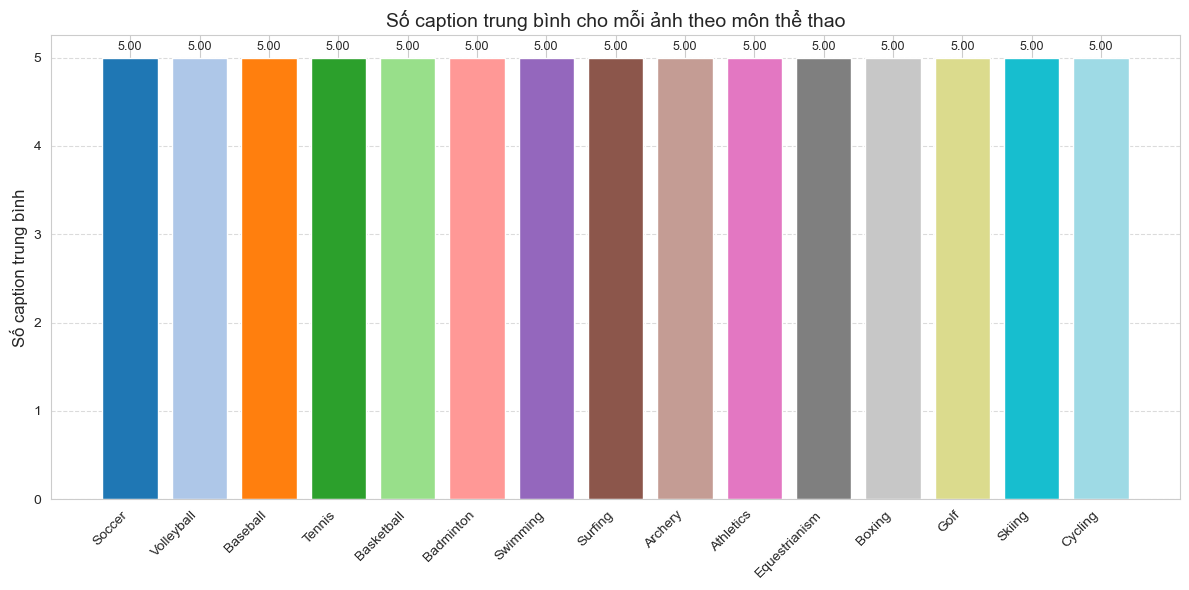

In [6]:
# Biểu đồ số caption trung bình cho mỗi ảnh
plt.figure(figsize=(12, 6))
bars = plt.bar(stats_df['Sport'], stats_df['Avg_Captions_Per_Image'], color=colors)
plt.title('Số caption trung bình cho mỗi ảnh theo môn thể thao', fontsize=14)
plt.ylabel('Số caption trung bình', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm giá trị trung bình lên biểu đồ
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "figures", "avg_captions_per_image.png"), dpi=300)
plt.show()

## 🖼 Image Analysis

In [7]:
# Phân tích kích thước ảnh
def analyze_image_size(image_path):
    try:
        img = Image.open(image_path)
        return img.size[0], img.size[1]  # (width, height)
    except Exception as e:
        return None, None

# Phân tích chất lượng ảnh
def analyze_image_quality(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        stat = ImageStat.Stat(img)
        brightness = sum(stat.mean) / 3  # Độ sáng trung bình
        contrast = sum(stat.stddev) / 3  # Độ tương phản
        return brightness, contrast
    except Exception as e:
        return None, None

# Nhận diện các ảnh gốc
def get_original_image_paths():
    sport_to_images = defaultdict(list)
    original_images = []
    
    # Tìm tất cả ảnh trong thư mục raw_images
    for root, _, files in os.walk(raw_images_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(root, file)
                sport = map_filename_to_sport(file)
                sport_to_images[sport].append((file, image_path))
                original_images.append((file, image_path, sport))
    
    return original_images, sport_to_images

Số ảnh được chọn mẫu để phân tích: 750


Analyzing images: 100%|██████████| 750/750 [00:25<00:00, 29.10it/s]


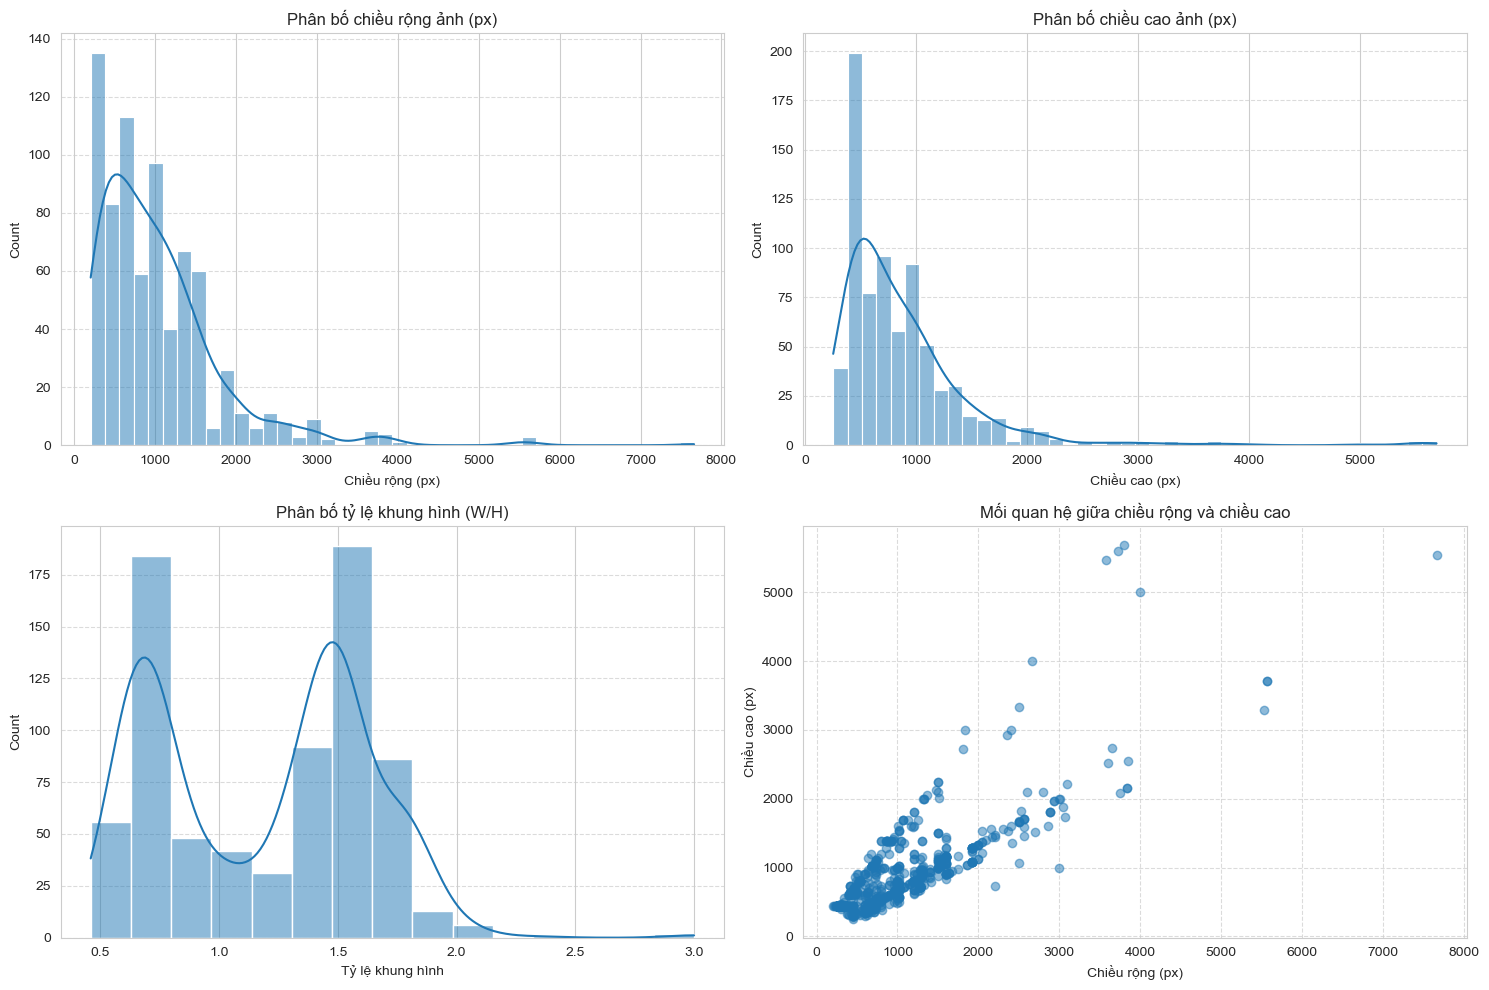

In [8]:
# Lấy danh sách các ảnh gốc
original_images, sport_to_images = get_original_image_paths()

# Lấy mẫu ngẫu nhiên từ mỗi môn thể thao để phân tích (tối đa 50 ảnh mỗi môn)
np.random.seed(42)
sample_images = []
for sport in sports:
    images = sport_to_images.get(sport, [])
    if images:
        sample_size = min(50, len(images))
        sport_samples = np.random.choice(len(images), sample_size, replace=False)
        sample_images.extend([images[i] for i in sport_samples])

print(f"Số ảnh được chọn mẫu để phân tích: {len(sample_images)}")

# Thu thập thông tin về kích thước và chất lượng ảnh
image_sizes = []
image_qualities = []
file_formats = []
file_sizes = []

for _, image_path in tqdm(sample_images, desc="Analyzing images"):
    # Kích thước ảnh (width, height)
    width, height = analyze_image_size(image_path)
    if width and height:
        image_sizes.append((width, height))
        
        # Chất lượng ảnh (brightness, contrast)
        brightness, contrast = analyze_image_quality(image_path)
        if brightness is not None:
            image_qualities.append((brightness, contrast))
        
        # Định dạng và kích thước file
        file_format = os.path.splitext(image_path)[1].lower()
        file_formats.append(file_format)
        file_sizes.append(os.path.getsize(image_path) / 1024)  # kB

# Tạo DataFrame để phân tích kích thước ảnh
if image_sizes:
    size_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
    size_df['Aspect_Ratio'] = size_df['Width'] / size_df['Height']
    
    # Tạo biểu đồ phân bố kích thước ảnh
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.histplot(size_df['Width'], kde=True)
    plt.title('Phân bố chiều rộng ảnh (px)', fontsize=12)
    plt.xlabel('Chiều rộng (px)', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(2, 2, 2)
    sns.histplot(size_df['Height'], kde=True)
    plt.title('Phân bố chiều cao ảnh (px)', fontsize=12)
    plt.xlabel('Chiều cao (px)', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(2, 2, 3)
    sns.histplot(size_df['Aspect_Ratio'], kde=True)
    plt.title('Phân bố tỷ lệ khung hình (W/H)', fontsize=12)
    plt.xlabel('Tỷ lệ khung hình', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(2, 2, 4)
    plt.scatter(size_df['Width'], size_df['Height'], alpha=0.5)
    plt.title('Mối quan hệ giữa chiều rộng và chiều cao', fontsize=12)
    plt.xlabel('Chiều rộng (px)', fontsize=10)
    plt.ylabel('Chiều cao (px)', fontsize=10)
    plt.grid(linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "figures", "image_size_distribution.png"), dpi=300)
    plt.show()
    
    # Lưu thông tin kích thước ảnh
    size_df.describe().to_csv(os.path.join(results_dir, "image_size_statistics.csv"))

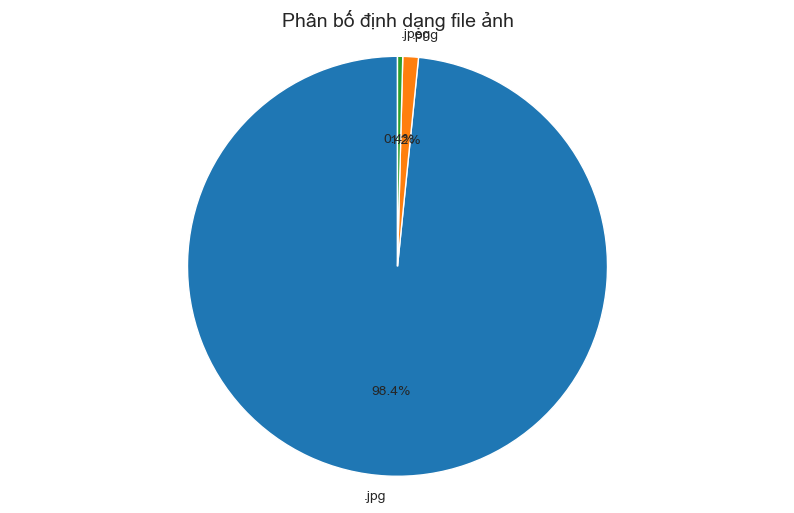

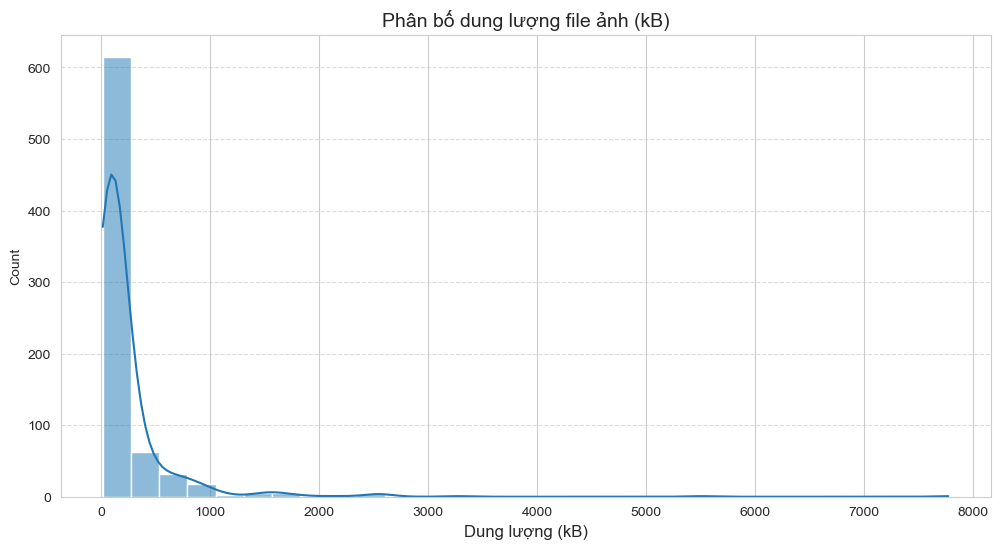

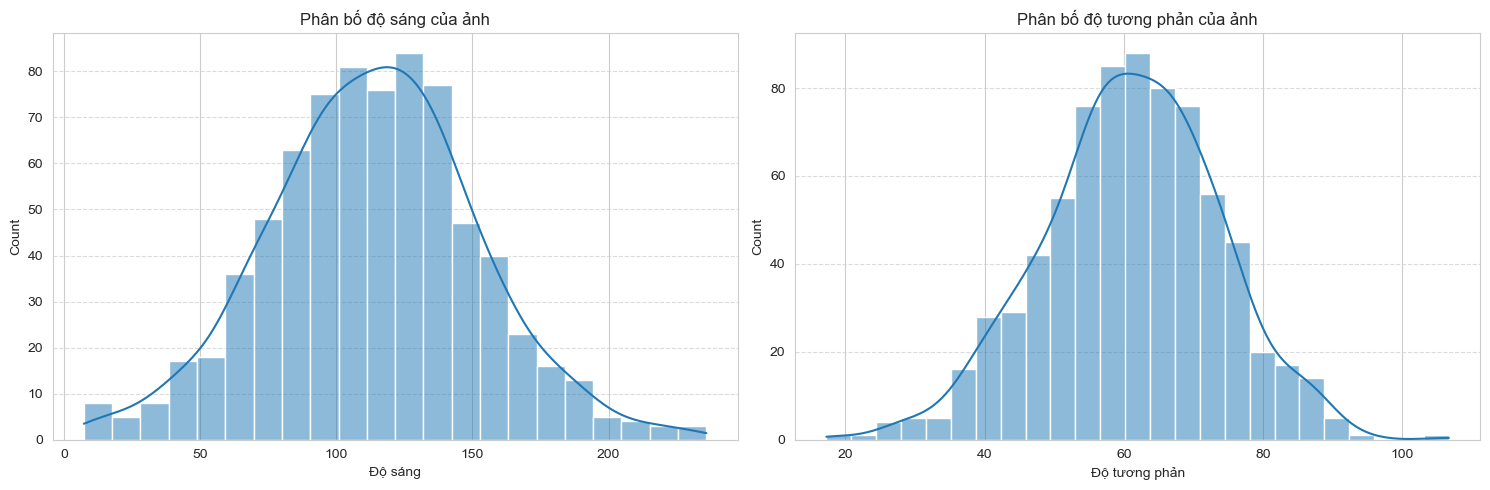

In [9]:
# Phân tích định dạng và dung lượng file
format_counts = Counter(file_formats)
format_df = pd.DataFrame({
    'Format': list(format_counts.keys()),
    'Count': list(format_counts.values())
})

# Biểu đồ định dạng file
plt.figure(figsize=(10, 6))
plt.pie(format_df['Count'], labels=format_df['Format'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Phân bố định dạng file ảnh', fontsize=14)
plt.savefig(os.path.join(results_dir, "figures", "image_format_distribution.png"), dpi=300)
plt.show()

# Biểu đồ dung lượng file
plt.figure(figsize=(12, 6))
sns.histplot(file_sizes, kde=True, bins=30)
plt.title('Phân bố dung lượng file ảnh (kB)', fontsize=14)
plt.xlabel('Dung lượng (kB)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(results_dir, "figures", "image_size_distribution_kb.png"), dpi=300)
plt.show()

# Nếu có dữ liệu về chất lượng ảnh
if image_qualities:
    quality_df = pd.DataFrame(image_qualities, columns=['Brightness', 'Contrast'])
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(quality_df['Brightness'], kde=True)
    plt.title('Phân bố độ sáng của ảnh', fontsize=12)
    plt.xlabel('Độ sáng', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    sns.histplot(quality_df['Contrast'], kde=True)
    plt.title('Phân bố độ tương phản của ảnh', fontsize=12)
    plt.xlabel('Độ tương phản', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "figures", "image_quality_distribution.png"), dpi=300)
    plt.show()

## 📝 Caption Analysis

In [10]:
# Tiền xử lý caption tiếng Việt đã được tokenize
def preprocess_vietnamese_caption(caption):
    # Chuyển về chữ thường
    caption = caption.lower()
    # Tách từ bằng khoảng trắng (vì từ ghép đã được VnCoreNLP xử lý với dấu gạch dưới)
    words = caption.split()
    return words

# Phân tích caption
caption_lengths = []
caption_word_counts = []
all_words = []
sport_words = defaultdict(list)

# Phân tích độ dài và tần suất từ trong caption
for image_name, caption in original_captions:
    caption_lengths.append(len(caption))
    
    # Xử lý caption tiếng Việt
    words = preprocess_vietnamese_caption(caption)
    caption_word_counts.append(len(words))
    
    # Lọc stopwords
    filtered_words = [word for word in words if word not in vietnamese_stopwords]
    all_words.extend(filtered_words)
    
    # Phân loại từ theo môn thể thao
    sport = map_filename_to_sport(image_name)
    if sport != "Unknown":
        sport_words[sport].extend(filtered_words)

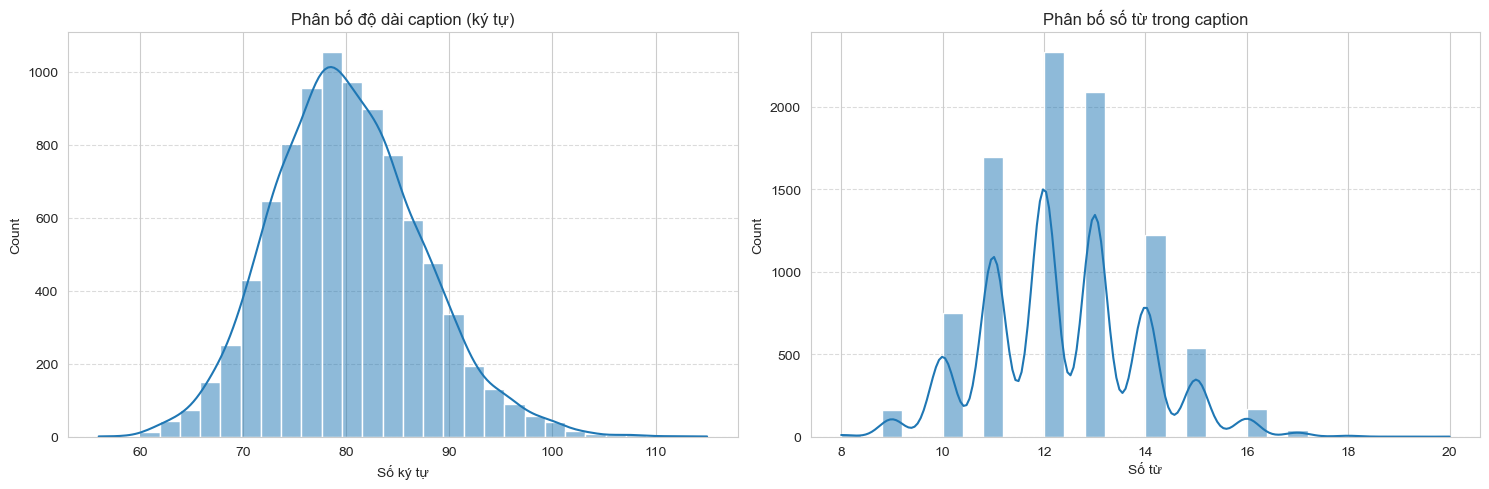

In [11]:
# Tạo biểu đồ phân bố độ dài caption
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(caption_lengths, kde=True, bins=30)
plt.title('Phân bố độ dài caption (ký tự)', fontsize=12)
plt.xlabel('Số ký tự', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.histplot(caption_word_counts, kde=True, bins=30)
plt.title('Phân bố số từ trong caption', fontsize=12)
plt.xlabel('Số từ', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "figures", "caption_length_distribution.png"), dpi=300)
plt.show()

In [12]:
# Thống kê về độ dài caption
caption_length_stats = {
    'Character_Count': {
        'Min': min(caption_lengths),
        'Max': max(caption_lengths),
        'Mean': np.mean(caption_lengths),
        'Median': np.median(caption_lengths),
        'Std': np.std(caption_lengths)
    },
    'Word_Count': {
        'Min': min(caption_word_counts),
        'Max': max(caption_word_counts),
        'Mean': np.mean(caption_word_counts),
        'Median': np.median(caption_word_counts),
        'Std': np.std(caption_word_counts)
    }
}

# Lưu thông tin thống kê về caption
pd.DataFrame(caption_length_stats).to_csv(os.path.join(results_dir, "caption_length_statistics.csv"))

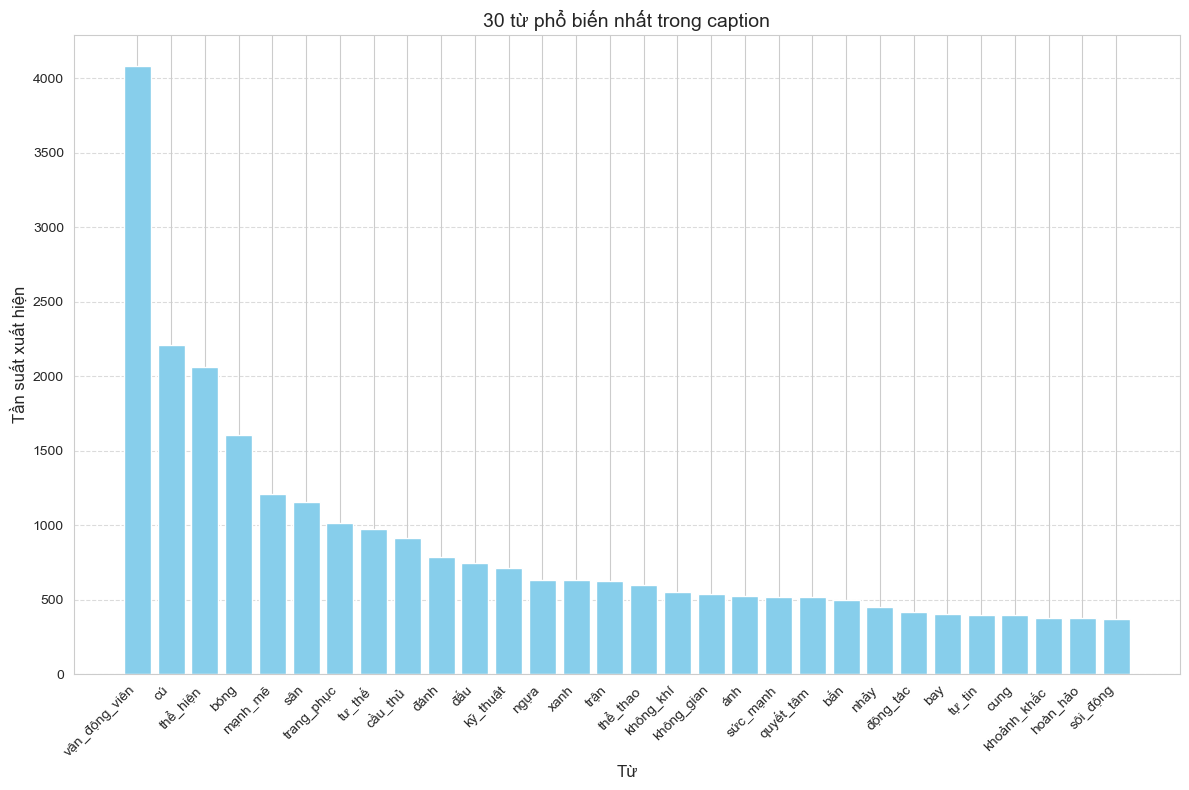

In [13]:
# Tạo biểu đồ tần suất từ (top 30)
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)

plt.figure(figsize=(12, 8))
words, counts = zip(*common_words)
plt.bar(words, counts, color='skyblue')
plt.title('30 từ phổ biến nhất trong caption', fontsize=14)
plt.xlabel('Từ', fontsize=12)
plt.ylabel('Tần suất xuất hiện', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "figures", "common_words.png"), dpi=300)
plt.show()

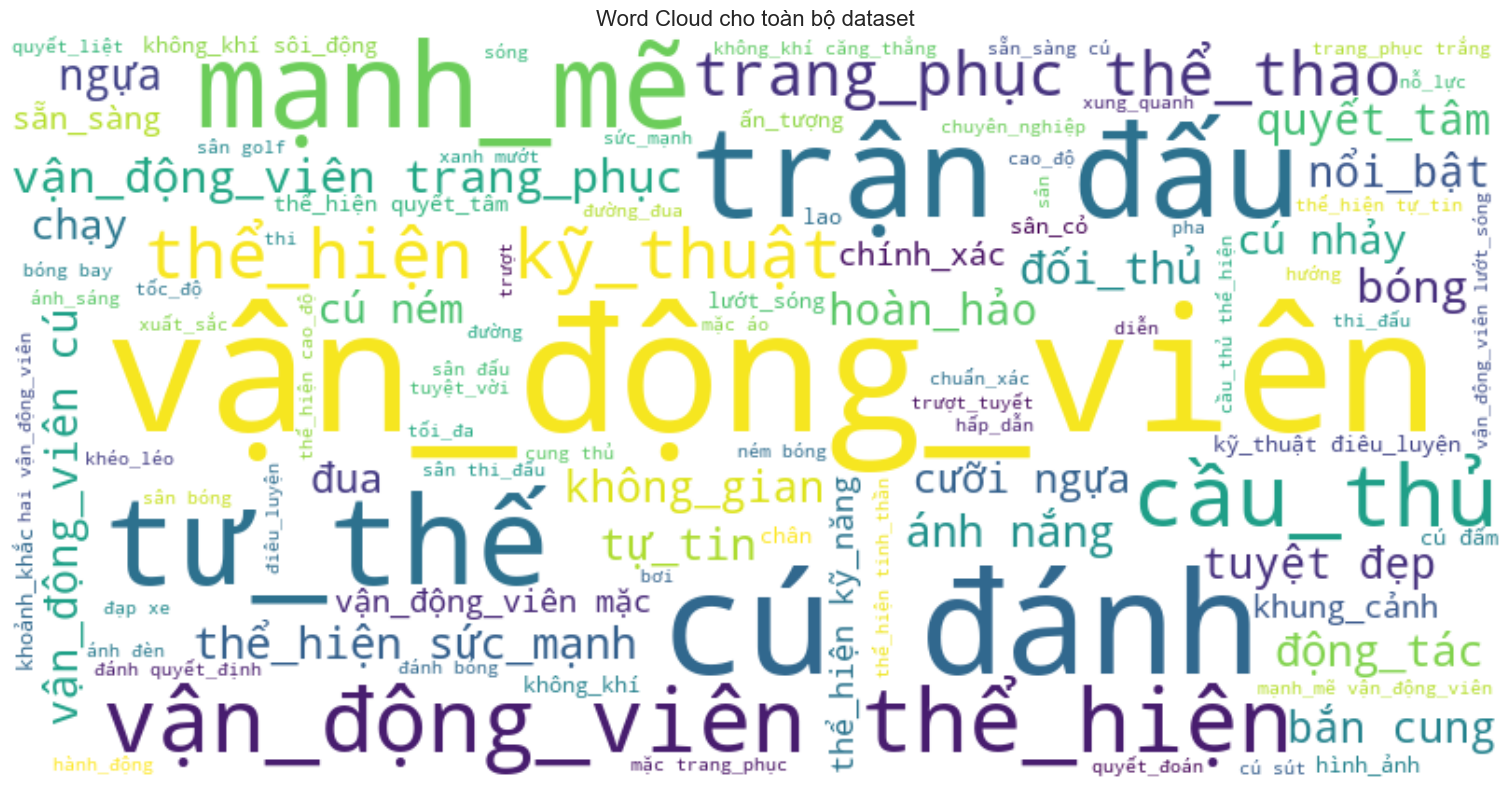

In [15]:
# Tạo word cloud cho toàn bộ dataset với font hỗ trợ tiếng Việt
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    stopwords=vietnamese_stopwords, 
    max_words=100
).generate(' '.join(all_words))

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud cho toàn bộ dataset', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "wordclouds", "all_captions_wordcloud.png"), dpi=300)
plt.show()

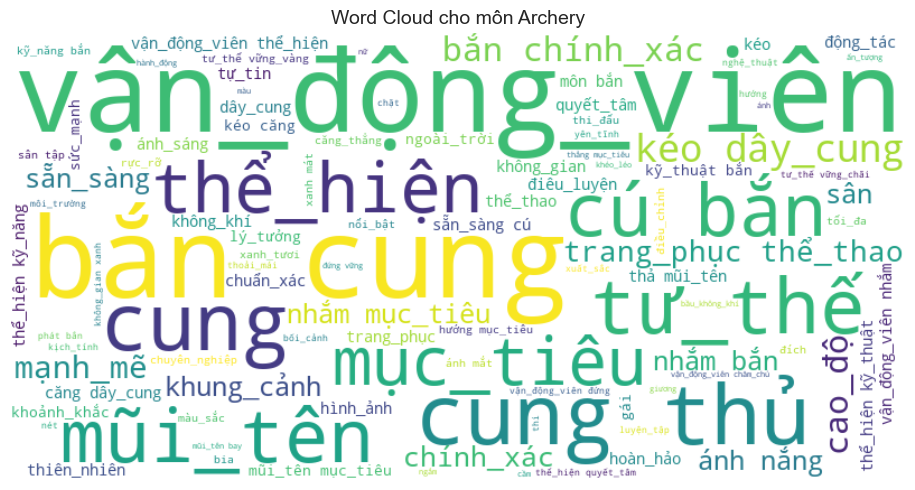

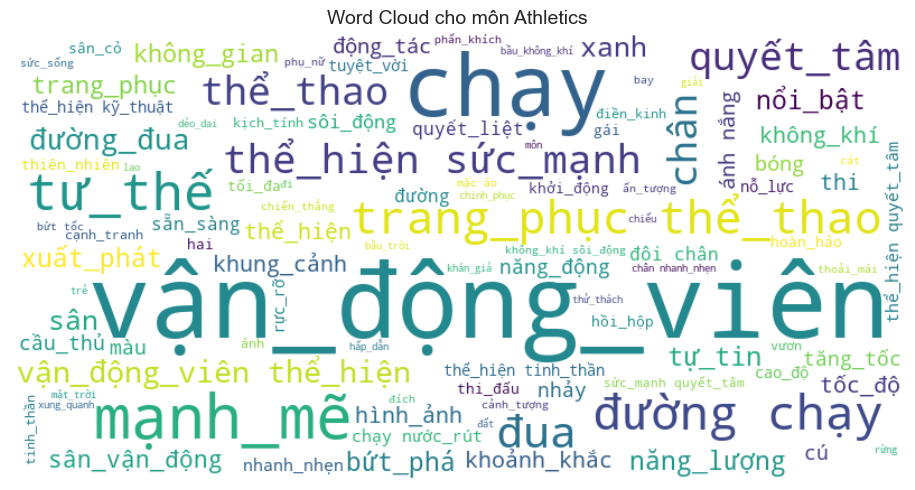

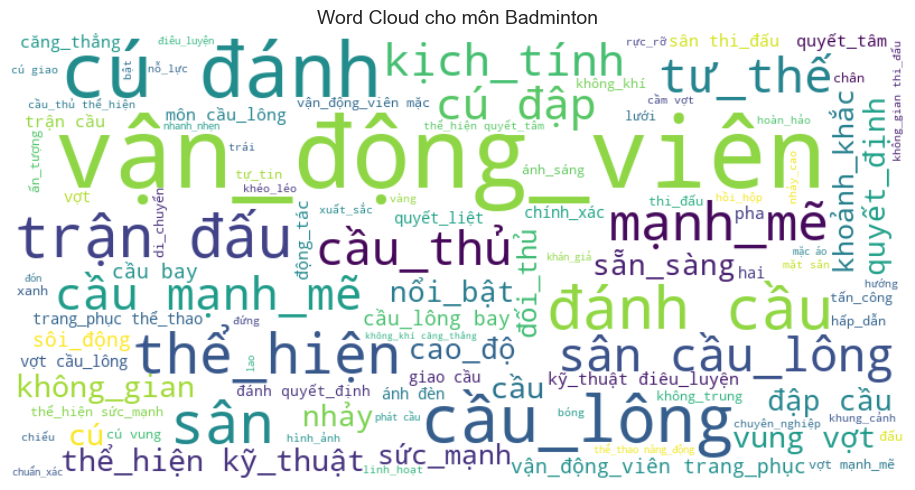

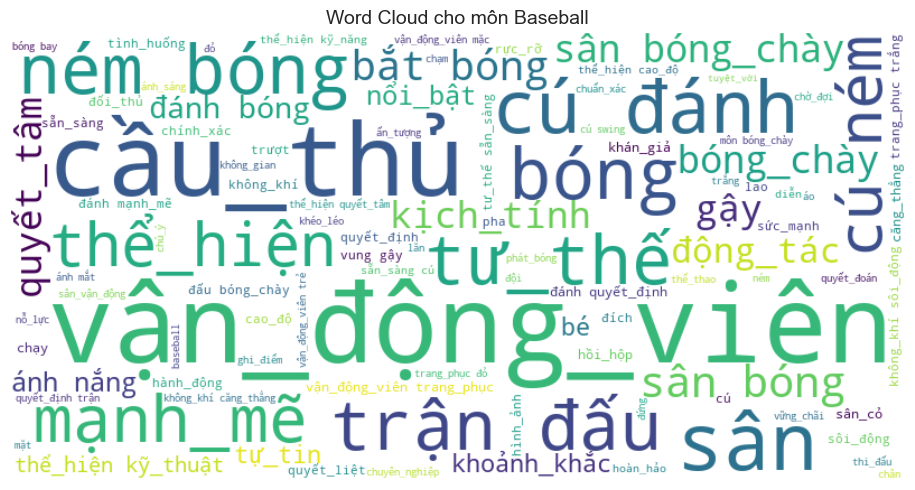

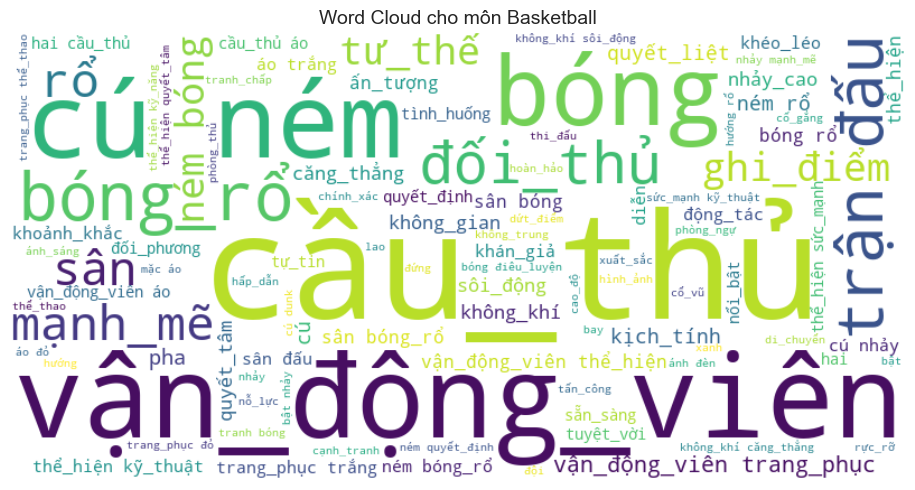

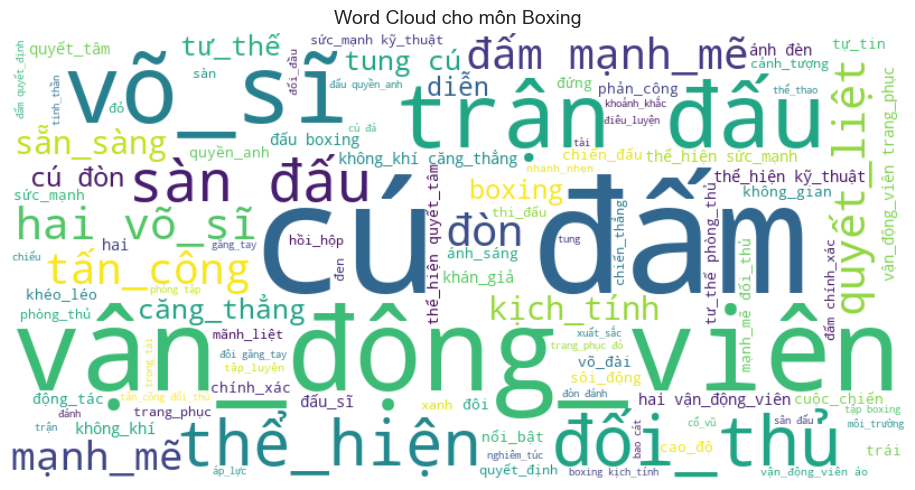

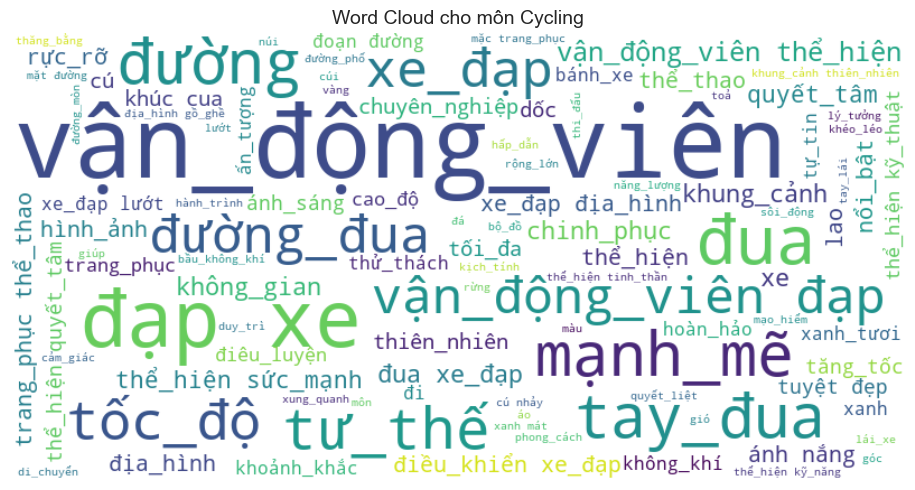

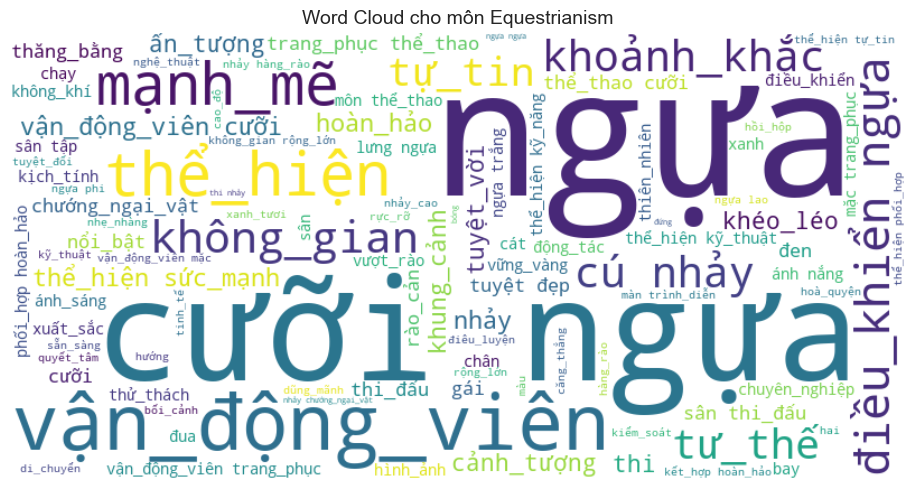

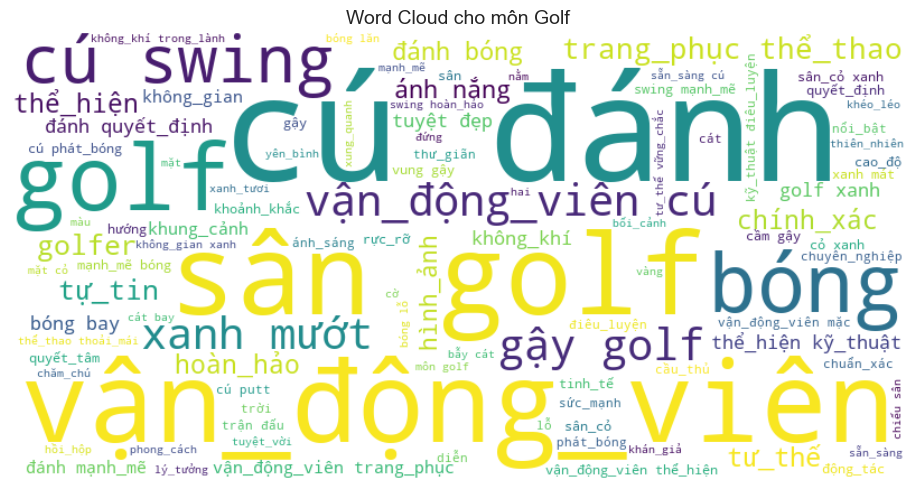

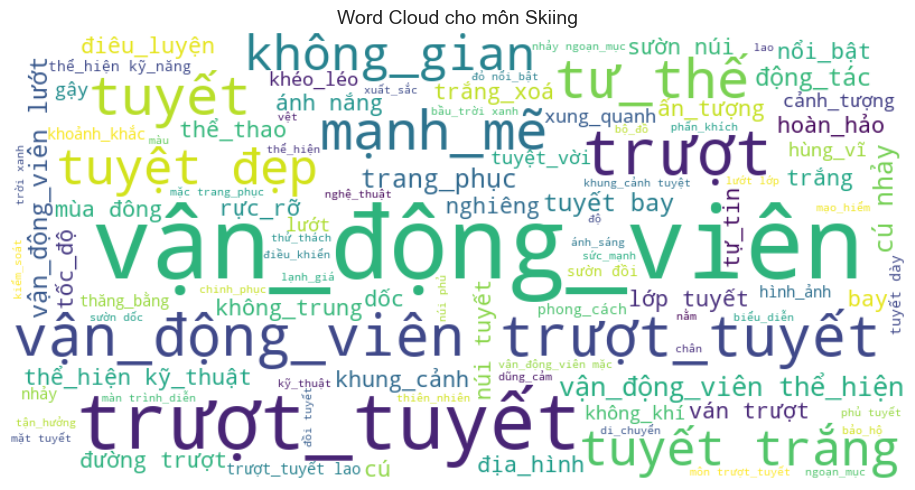

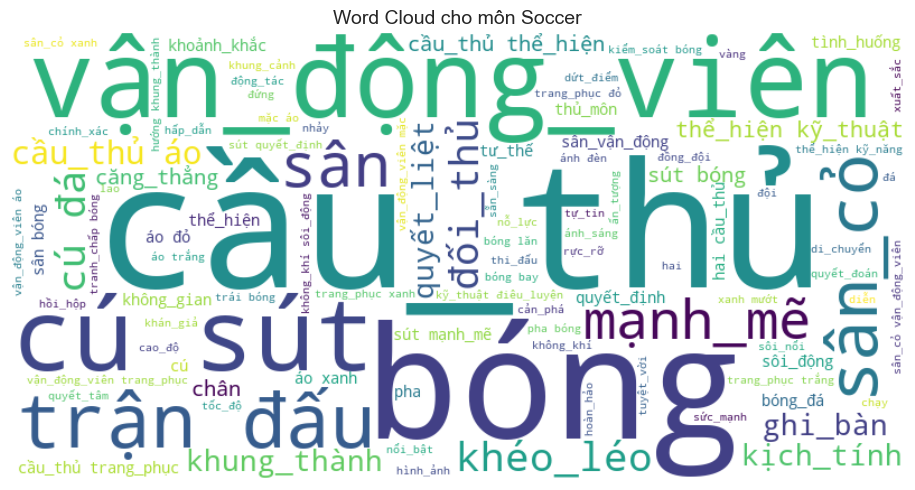

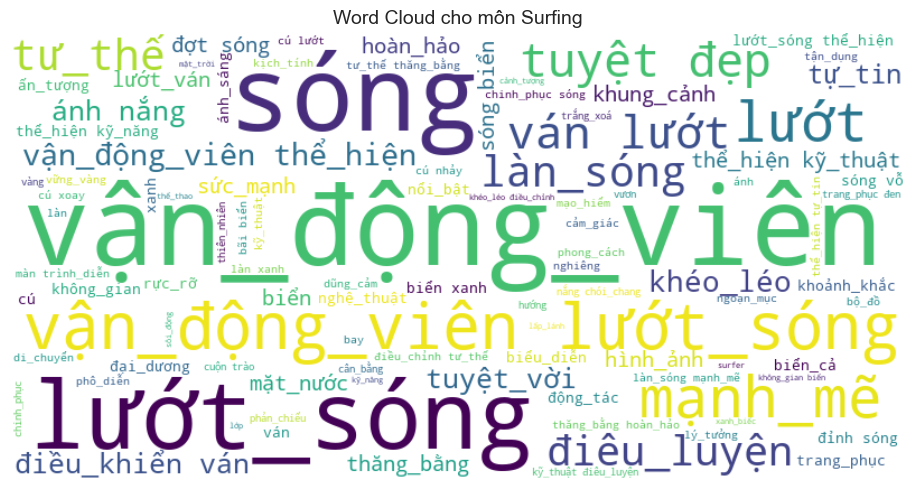

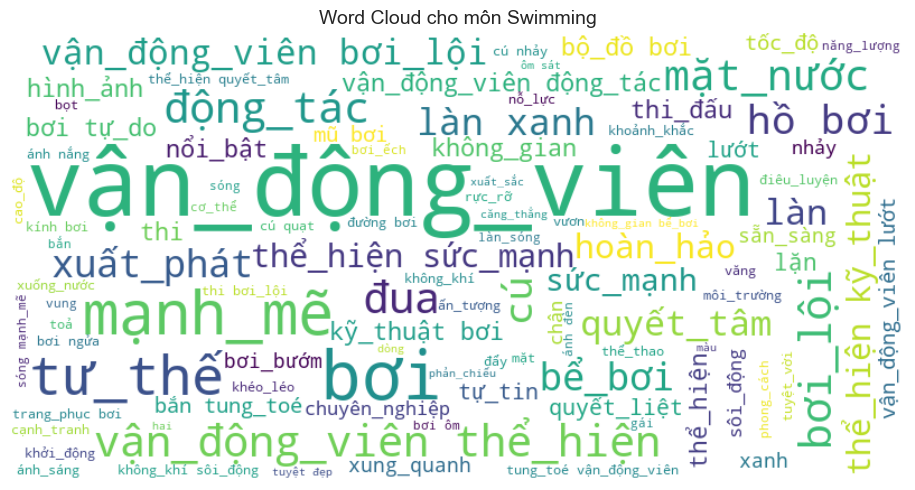

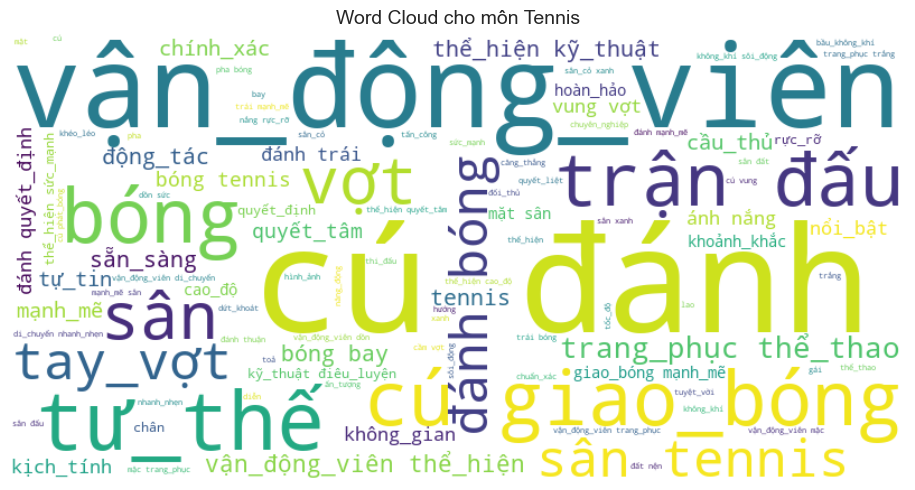

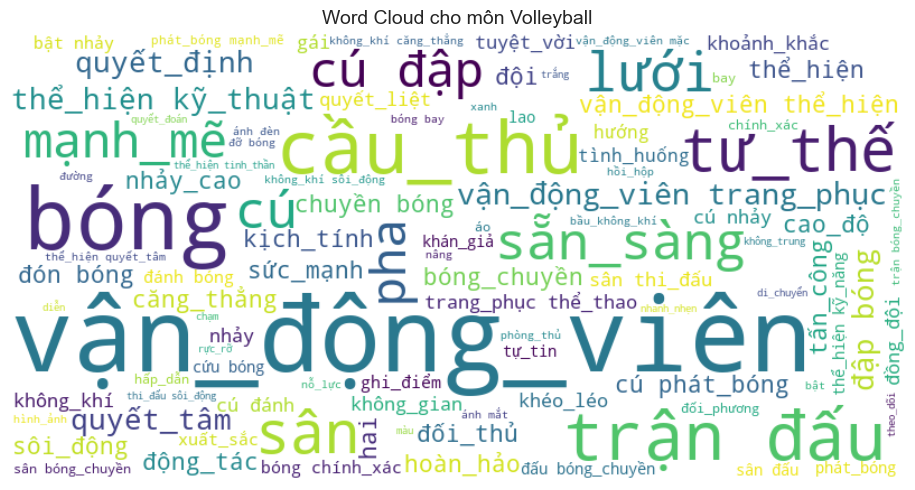

In [17]:
# Tạo word cloud cho từng môn thể thao
for sport, words in sport_words.items():
    if words:  # Chỉ tạo word cloud nếu có từ
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white', 
            stopwords=vietnamese_stopwords, 
            max_words=100
        ).generate(' '.join(words))
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud cho môn {sport}', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(results_dir, "wordclouds", f"{sport.lower()}_wordcloud.png"), dpi=300)
        plt.show()

In [18]:
# Thống kê số lượng từ đặc trưng cho từng môn thể thao
sport_specific_words = {}
for sport in sports:
    if sport not in sport_words:
        continue
        
    # Tính tần suất từ trong môn thể thao hiện tại
    sport_word_freq = Counter(sport_words[sport])
    
    # Tính tổng số từ trong môn thể thao
    total_words = len(sport_words[sport])
    
    # Tính tần suất từ trong các môn thể thao khác
    other_sports_words = []
    for other_sport, words in sport_words.items():
        if other_sport != sport:
            other_sports_words.extend(words)
    
    other_word_freq = Counter(other_sports_words)
    total_other_words = len(other_sports_words)
    
    # Tính độ đặc trưng của từ
    distinctive_words = []
    
    for word, count in sport_word_freq.items():
        if count >= 5:  # Chỉ xét các từ xuất hiện ít nhất 5 lần
            freq_in_sport = count / total_words
            freq_in_others = other_word_freq.get(word, 0) / max(1, total_other_words)
            
            # Tính độ đặc trưng (distinctiveness)
            distinctiveness = freq_in_sport / max(0.0001, freq_in_others)
            
            if distinctiveness > 1.5:  # Chỉ lấy những từ có độ đặc trưng đủ lớn
                distinctive_words.append((word, count, distinctiveness))
    
    # Sắp xếp theo độ đặc trưng giảm dần
    distinctive_words.sort(key=lambda x: x[2], reverse=True)
    
    # Lấy 20 từ đặc trưng nhất
    top_distinctive = distinctive_words[:20]
    sport_specific_words[sport] = top_distinctive

# Lưu danh sách từ đặc trưng cho mỗi môn thể thao
with open(os.path.join(results_dir, "sport_specific_words.txt"), 'w', encoding='utf-8') as f:
    for sport, words in sport_specific_words.items():
        f.write(f"Từ đặc trưng cho môn {sport}:\n")
        for word, count, distinctiveness in words:
            f.write(f"{word}: xuất hiện {count} lần, độ đặc trưng: {distinctiveness:.2f}\n")
        f.write("\n" + "-"*50 + "\n\n")

In [19]:
# Phân tích sự khác biệt về độ dài caption giữa các môn thể thao
sport_caption_lengths = defaultdict(list)
sport_caption_word_counts = defaultdict(list)

for image_name, caption in original_captions:
    sport = map_filename_to_sport(image_name)
    if sport != "Unknown":
        sport_caption_lengths[sport].append(len(caption))
        
        # Số từ trong caption
        words = preprocess_vietnamese_caption(caption)
        sport_caption_word_counts[sport].append(len(words))

# Tạo DataFrame để so sánh độ dài caption giữa các môn
caption_length_by_sport = []
for sport in sports:
    if sport in sport_caption_lengths and sport_caption_lengths[sport]:
        caption_length_by_sport.append({
            'Sport': sport,
            'Mean_Char_Length': np.mean(sport_caption_lengths[sport]),
            'Mean_Word_Count': np.mean(sport_caption_word_counts[sport]),
            'Min_Char_Length': min(sport_caption_lengths[sport]),
            'Max_Char_Length': max(sport_caption_lengths[sport]),
            'Min_Word_Count': min(sport_caption_word_counts[sport]),
            'Max_Word_Count': max(sport_caption_word_counts[sport])
        })

caption_length_df = pd.DataFrame(caption_length_by_sport)
caption_length_df.to_csv(os.path.join(results_dir, "caption_length_by_sport.csv"), index=False)

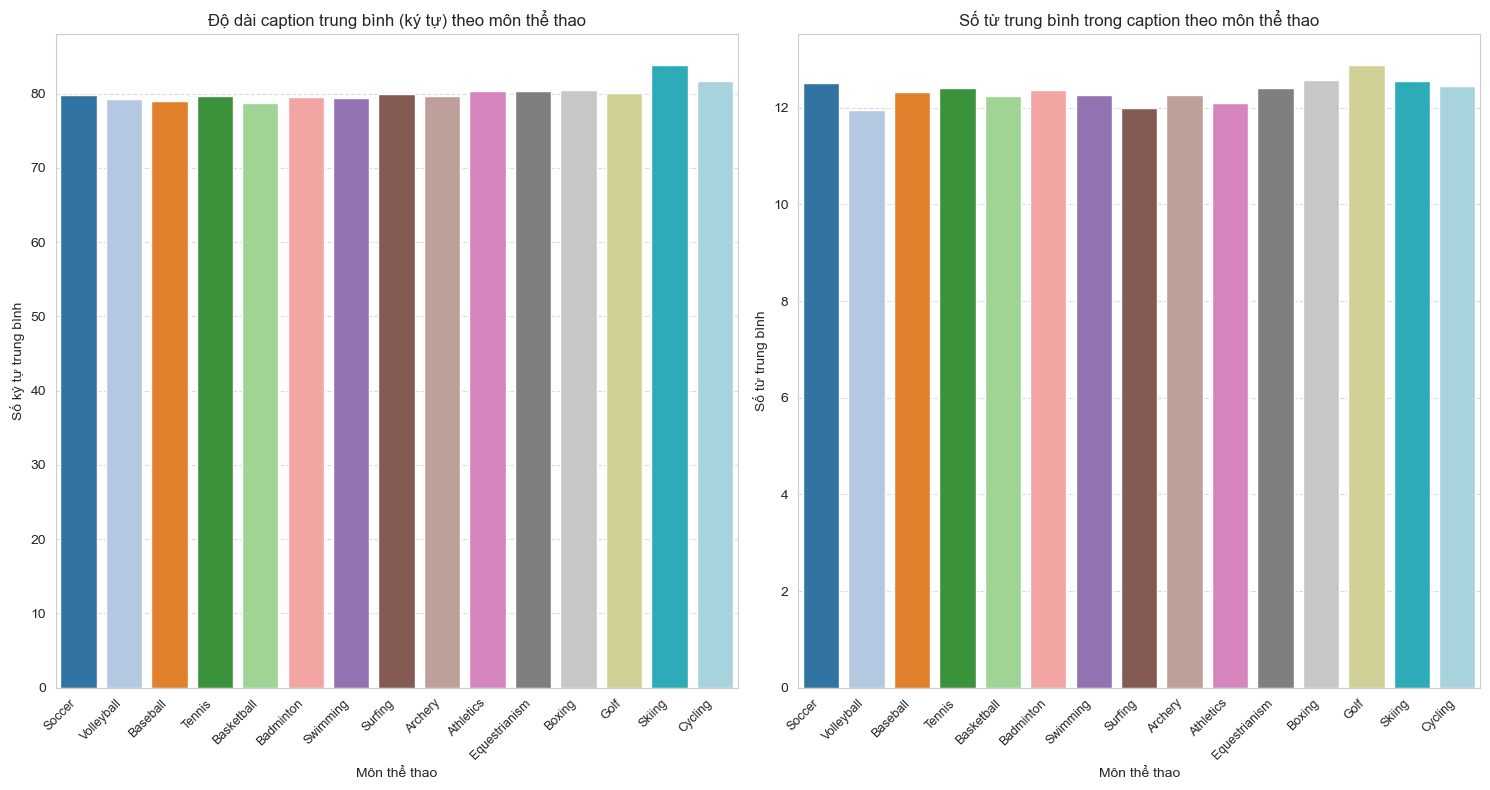

In [20]:
# Biểu đồ so sánh độ dài caption giữa các môn thể thao
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
sns.barplot(x='Sport', y='Mean_Char_Length', data=caption_length_df, palette=colors[:len(caption_length_df)])
plt.title('Độ dài caption trung bình (ký tự) theo môn thể thao', fontsize=12)
plt.xlabel('Môn thể thao', fontsize=10)
plt.ylabel('Số ký tự trung bình', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.barplot(x='Sport', y='Mean_Word_Count', data=caption_length_df, palette=colors[:len(caption_length_df)])
plt.title('Số từ trung bình trong caption theo môn thể thao', fontsize=12)
plt.xlabel('Môn thể thao', fontsize=10)
plt.ylabel('Số từ trung bình', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "figures", "caption_length_by_sport.png"), dpi=300)
plt.show()